<a href="https://colab.research.google.com/github/oaargueyo/styleit_colab_research/blob/main/Research_for_POC_Detectron_Google_Image_Reverse_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Research use of Detectron2, Serper and Serpapi


# Install detectron2 and pycocotools and all necessary packages for this research

In [ ]:
!python -m pip install pyyaml==5.1
!python -m pip install cudatoolkit==10.2
!python -m pip install pycocotools pyimgur requests google-search-results

import sys, os, distutils.core

!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 6.9 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
ERROR: Could not find a version that satisfies the requirement cudatoolkit==10.2 (from versions: none)
ERROR: No matching distribution found for cudatoolkit==10.2
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pyimgur: filename=pyimgur-0.6.0-py3-none-any.whl size=32423 sha256=85d943bc16c60f50abd5e0b3d45908681ef340d8e9165a5eed6dc0647462e2f5
  Stored in directory: /root/.cache/

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.5 ; cuda:  cu121
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Run a pre-trained detectron2 model

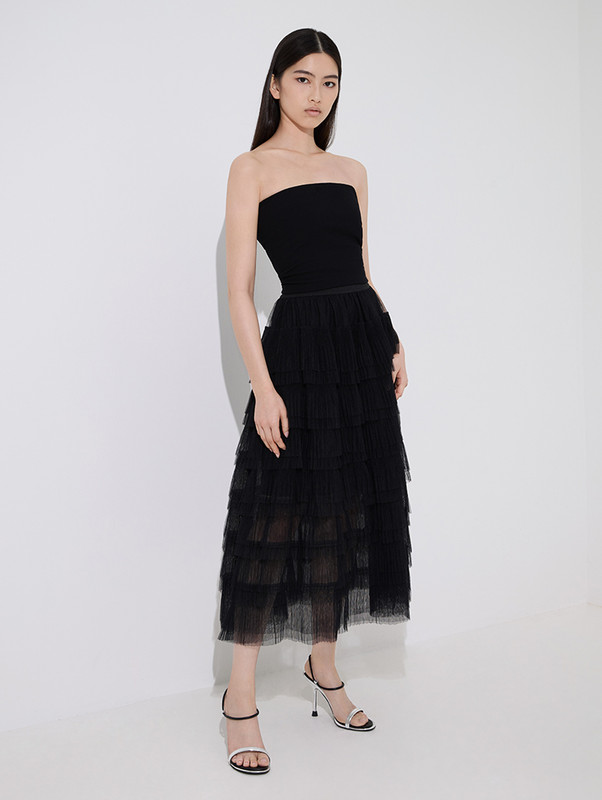

In [ ]:
!wget https://i.postimg.cc/0jkt6KPc/charles-keith-spring-24-wedding-guest-blog-09.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")
cv2_imshow(im)

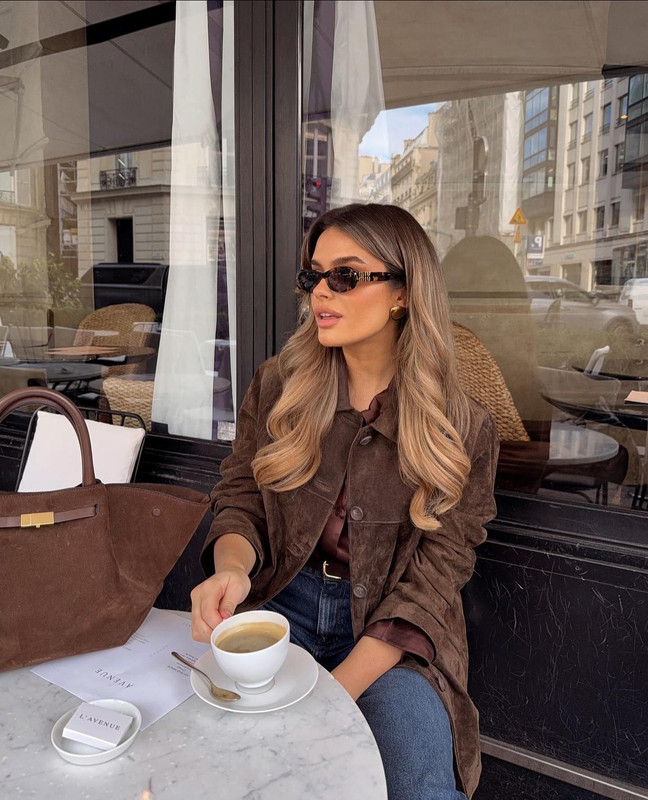

In [ ]:
!wget https://i.postimg.cc/Pxb4HVQJ/462533434-885619676998102-3587688954556275068-n.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")
cv2_imshow(im)

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)


[11/21 22:23:25 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:00, 211MB/s]                           


In [ ]:
outputs = predictor(im)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)


tensor([0], device='cuda:0')
Boxes(tensor([[210.7801,  25.7220, 416.4366, 775.5065]], device='cuda:0'))


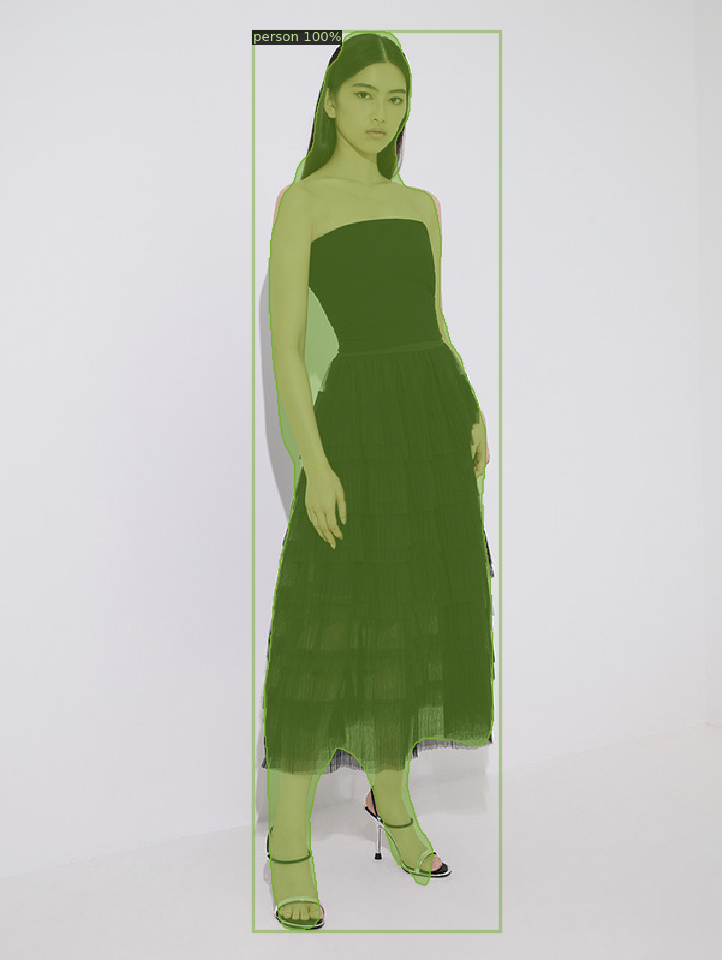

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

For detected objects, use them as they are. However, if the label "person" is identified, split the image into four sections: the upper part, two middle sections, and one lower section. These sections can then be used to apply the reverse image API more effectively.


In [ ]:
import pyimgur
CLIENT_ID = 'CLIENT_ID'
# Initialize Imgur
im_client = pyimgur.Imgur(CLIENT_ID)

# List to store Imgur links
imgur_links = []

# Function to upload image to Imgur
def upload_to_imgur(image_path, title="Uploaded with PyImgur"):
    uploaded_image = im_client.upload_image(image_path, title=title)
    return uploaded_image.link

In [ ]:
from detectron2.structures import Boxes

# Extract the instances
instances = outputs["instances"].to("cpu")
classes = instances.pred_classes  # Class indices of detected objects
num_instances = len(instances)
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
class_names = metadata.get("thing_classes", [])  # List of class names


boxes = instances.pred_boxes if instances.has("pred_boxes") else Boxes()

# Iterate through each detected instance and crop the image
for i, box in enumerate(boxes):
    # Get the coordinates of the bounding box
    x1, y1, x2, y2 = map(int, box)

    # Crop the image using the bounding box coordinates
    cropped_image = im[y1:y2, x1:x2]
    # Get the class label for the current instance
    class_index = classes[i]
    class_label = class_names[class_index] if class_index < len(class_names) else "unknown"

    # Format the filename to include the class label
    output_path = f"cropped_instance_{class_label}_{i + 1}.jpg"
    cv2.imwrite(output_path, cropped_image)
    # Upload the image to Imgur and store the link
    imgur_link = upload_to_imgur(output_path, title=f"Instance: {class_label}")
    imgur_links.append(imgur_link)
    print(f"Saved and uploaded: {output_path}, Link: {imgur_link}")
    print(f"Saved: {output_path}")

Saved and uploaded: cropped_instance_person_1.jpg, Link: https://i.imgur.com/S9eEZ0Z.jpeg
Saved: cropped_instance_person_1.jpg


In [ ]:
import pprint
pprint.pprint(imgur_links)


['https://i.imgur.com/S9eEZ0Z.jpeg',
 'https://i.imgur.com/Gk1qpHS.jpeg',
 'https://i.imgur.com/ti2dGS3.jpeg',
 'https://i.imgur.com/WlfrDZH.jpeg']


In [ ]:
import os

# Load the image
image_path = "cropped_instance_person_1.jpg"
image = cv2.imread(image_path)

# Get the image dimensions
height, width, _ = image.shape

# Calculate the split points
top_split = int(0.25 * height)
bottom_split = int(0.75 * height)

# Slice the image into three parts
top_image = image[:top_split, :]
middle_image = image[top_split:bottom_split, :]
bottom_image = image[bottom_split:, :]

# Extract the last part of the filename without the directory path and extension
filename = os.path.splitext(os.path.basename(image_path))[0]

# Save the images with the new names
cv2.imwrite(f"{filename}_top.jpg", top_image)
cv2.imwrite(f"{filename}_middle.jpg", middle_image)
cv2.imwrite(f"{filename}_bottom.jpg", bottom_image)
imgur_link = upload_to_imgur(f"{filename}_top.jpg", title=f"{filename}_top")
imgur_links.append(imgur_link)
imgur_link = upload_to_imgur(f"{filename}_middle.jpg", title=f"{filename}_middle")
imgur_links.append(imgur_link)
imgur_link = upload_to_imgur(f"{filename}_bottom.jpg", title=f"{filename}_bottom")
imgur_links.append(imgur_link)


Based on the images obtained with Detectron and their classes, we upload them as public links to Imgur. Then, we upload them to the Google API using a wrapper.


In [ ]:
import requests
SERPER_API_KEY = 'SERPER_API_KEY'
def filter_us_retailers_and_marketplaces(results):
    # List of US-based retailer and marketplace domains without .com
    allowed_domains = [
         'amazon', 'ebay', 'walmart', 'target', 'bestbuy',
        'homedepot', 'macys', 'costco', 'lowes', 'kohl'
    ]
    filtered_results = []

    for result in results:
        domain = result.get('source', '').lower()  # Convert domain to lowercase
        if any(allowed_domain in domain for allowed_domain in allowed_domains):
            filtered_results.append(result)

    return filtered_results


def upload_to_serper(image_url):
    url = "https://google.serper.dev/lens"
    payload = json.dumps({
        "url": image_url,
        "location": "United States",
    })
    headers = {
        "X-API-KEY": SERPER_API_KEY,
        "Content-Type": "application/json"
    }
    response = requests.post(url, headers=headers, data=payload)
    return response.json()

In [ ]:
for image_url in imgur_links:
    response = upload_to_serper(image_url=image_url)

    filtered_response = filter_us_retailers_and_marketplaces(response.get("organic", []))
    pprint.pprint(response.get('searchParameters'))
    pprint.pprint(filtered_response)

{'engine': 'google',
 'gl': 'us',
 'location': 'United States',
 'type': 'lens',
 'url': 'https://i.imgur.com/S9eEZ0Z.jpeg'}
[]
{'engine': 'google',
 'gl': 'us',
 'location': 'United States',
 'type': 'lens',
 'url': 'https://i.imgur.com/Gk1qpHS.jpeg'}
[]
{'engine': 'google',
 'gl': 'us',
 'location': 'United States',
 'type': 'lens',
 'url': 'https://i.imgur.com/ti2dGS3.jpeg'}
[{'imageUrl': 'https://encrypted-tbn3.gstatic.com/images?q=tbn:ANd9GcRRXIHXmOLTsZIRHsBChtOCqqBjh2JGNCq6-M6s4RiwAvqNVC-I',
  'link': 'https://m.shein.com/us/Ruffle-Trim-Mesh-Overlay-Skirt-p-20082928-cat-1732.html?lang=en&ref=m&rep=dir&ret=mus',
  'source': 'Shein',
  'title': 'SHEIN Modely Ruffle Trim Mesh Overlay Skirt | SHEIN USA'},
 {'imageUrl': 'https://encrypted-tbn1.gstatic.com/images?q=tbn:ANd9GcQNUROOUGE3rR2iMz5e0IZ4edfspLLY9SoJl5-ec4bLO_zTG4H9',
  'link': 'https://ar.shein.com/SHEIN-MULTIPLE-Dobby-Mesh-Layered-Hem-Skirt-p-9257512-cat-1732.html',
  'source': 'Shein',
  'title': 'SHEIN Modely Dobby Mesh La

Same example with the serpapi library using Google Reverse Image

In [ ]:
!python -m pip install google-search-results

In [ ]:
from serpapi import GoogleSearch

def reverse_image_search(image_urls, api_key):
    search_results = []

    for image_url in image_urls:
        params = {
            "api_key": api_key,
            "engine": "google_reverse_image",
            "google_domain": "google.com",
            "image_url": image_url,
            "hl": "en",
            "gl": "us",
            "location": "United States"
        }

        try:
            search = GoogleSearch(params)
            results = search.get_dict()
            search_results.append(results)
        except Exception as e:
            print(f"Error performing search for {image_url}: {e}")
            search_results.append(None)

    return search_results

In [ ]:
api_key = "REVERSE_IMAGE_API_KEY"

results = reverse_image_search(imgur_links, api_key)

for index, result in enumerate(results):
    if result:
        pprint.pprint(f"Results for image {index + 1}: {result}")
    else:
        pprint.pprint(f"Failed to get results for image {index + 1}")

("Results for image 1: {'search_metadata': {'id': '673d457707c7bed17b909fef', "
 "'status': 'Success', 'json_endpoint': "
 "'https://serpapi.com/searches/f8e063a24a583598/673d457707c7bed17b909fef.json', "
 "'created_at': '2024-11-20 02:12:07 UTC', 'processed_at': '2024-11-20 "
 "02:12:07 UTC', 'google_reverse_image_url': "
 "'https://www.google.com/searchbyimage?image_url=https://i.imgur.com/sMcGT94.jpeg&uule=w+CAIQICINVW5pdGVkIFN0YXRlcw&hl=en&gl=us&sbisrc=cr_1_5_2', "
 "'raw_html_file': "
 "'https://serpapi.com/searches/f8e063a24a583598/673d457707c7bed17b909fef.html', "
 "'total_time_taken': 3.12}, 'search_parameters': {'engine': "
 "'google_reverse_image', 'image_url': 'https://i.imgur.com/sMcGT94.jpeg', "
 "'location_requested': 'United States', 'location_used': 'United States', "
 "'google_domain': 'google.com', 'hl': 'en', 'gl': 'us', 'device': 'desktop'}, "
 "'search_information': {'organic_results_state': 'Fully empty', "
 '\'query_displayed\': \'\'}, \'error\': "Google Reverse 

In [ ]:
!python -m pip freeze > requirements.txt

In [ ]:
!python --version

Python 3.10.12
